# Titanic: Machine Learning from Disaster #
### Logistic Regression ###

## Packages ##

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression

## Training Set Exploration & Engineering ##

### Loading the Training and Test Sets ###
Loading training and test sets and combining them for several of the engineering tasks. Dropping the PassengerId column (since it has no purpose in the training), as well as the Name and Ticket columns (since these are random and will not have an effect on whether passengers survived or not).

In [2]:
train_raw = pd.read_csv("Data/train.csv")
test_raw = pd.read_csv("Data/test.csv")

train = train_raw.copy(deep = True)
test = test_raw.copy(deep = True)

all_data = pd.concat([train, test], axis = 0, join = "outer", ignore_index = True, sort = False)
all_data = all_data.drop(columns = ['PassengerId', 'Name', 'Ticket'])

### Dealing with Missing Values ###

#### Checking which features have missing values ####
Note: Because the training and test sets are combined, Survived will be missing 418 values, corresponding to the 418 observations of the test. set

In [3]:
all_data.isnull().sum()

Survived     418
Pclass         0
Sex            0
Age          263
SibSp          0
Parch          0
Fare           1
Cabin       1014
Embarked       2
dtype: int64

#### Dropping Cabin ####
Because of the very high percentage of missingness, Cabin will not be helpful in creating the model, so it is dropped.

In [4]:
all_data = all_data.drop(columns = ['Cabin'])

#### Imputing for Age ####
Age is potentially an important feature for the model. However, there are 263 missing observations. Instead of simply using the mean or median age to impute the missing values, I used Parch, to estimate ages, since certain Parch values will likely correspond to certain age groups.

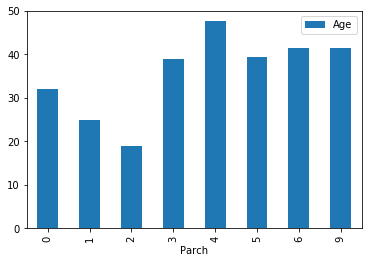

In [5]:
# calculating average age by Parch

age_parch = all_data[['Age', 'Parch']].copy(deep = True)
age_parch_mean = age_parch.copy(deep = True).groupby(by = 'Parch').mean()
age_parch_mean.loc[9] = age_parch_mean.loc[6]

age_parch_plot = age_parch_mean.plot.bar()

As seen above, mean age by Parch value is significantly different between 0 and 2 than other values.

In [6]:
# imputing age for all null ages

def estimateAge(parch):
    return round((age_parch_mean.loc[parch]),1)[0]

age_parch['estimatedAges'] = age_parch['Parch'].apply(estimateAge)
age_parch['Age'] = age_parch['Age'].fillna(age_parch['estimatedAges'])
all_data['Age'] = age_parch['Age']

#### Imputing for Fare ####
Similarly to how the age may be affected by Parch, I used Pclass to help determine the approximate fare cost.

In [7]:
fare_class = all_data[['Fare', 'Pclass']].copy(deep = True)
fare_class_mean = fare_class.copy(deep = True).groupby(by = 'Pclass').mean()
all_data['Fare'] = all_data['Fare'].fillna(fare_class_mean.loc[3][0])

#### Imputing for Embarked ####
I simply used the mode to impute for the missing Embarked values.

In [8]:
all_data['Embarked'].fillna(all_data['Embarked'].mode()[0], inplace = True)

### Visualizing Features' Relationship with Survival Rate ###

In [9]:
# extracting the training data from the full data set

train_1 = all_data[0:train.shape[0]]

In [10]:
# Creating bins for the continuous variables, Age and Fare.

age_surv = train_1[['Age', 'Survived']].copy(deep = True)
age_surv['Age'] = pd.cut(age_surv['Age'], bins = 10, 
                         labels = ['5%', '15%', '25%', '35%', '45%', '55%', '65%', '75%', '85%', '95%'])

fare_surv = train_1[['Fare', 'Survived']].copy(deep = True)
fare_surv['Fare'] = pd.cut(fare_surv['Fare'], bins = 10, 
                         labels = ['5%', '15%', '25%', '35%', '45%', '55%', '65%', '75%', '85%', '95%'])

C:\Users\Phoenix\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


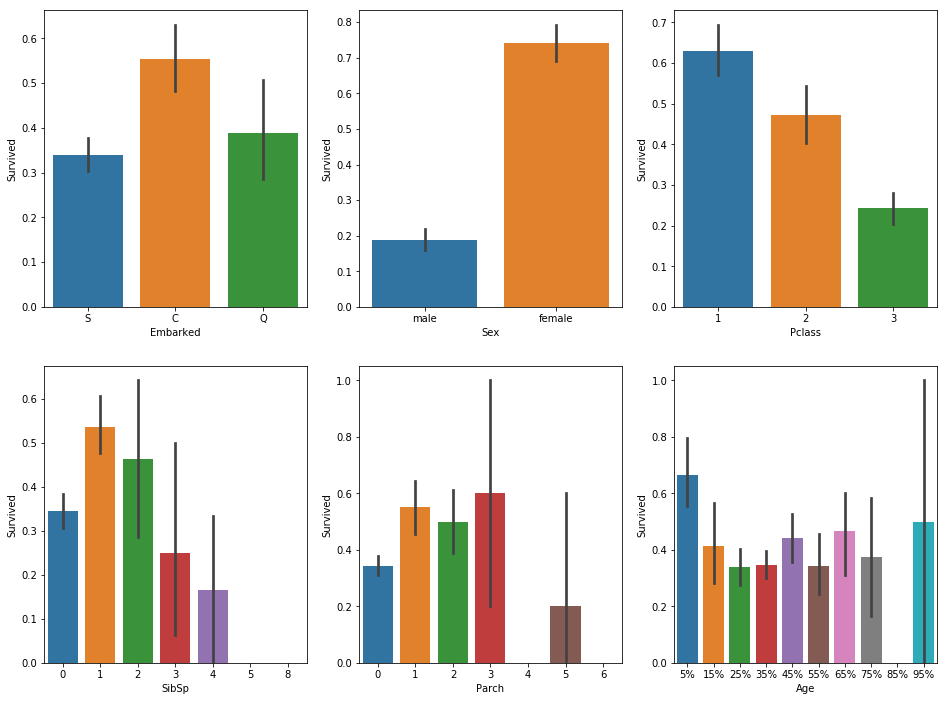

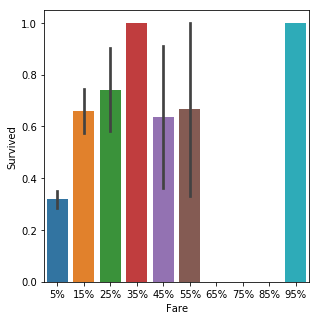

In [11]:
fig, axis = plt.subplots(2, 3, figsize=(16,12))
sns.barplot(x = 'Embarked', y = 'Survived', data = train_1, ax = axis[0,0])
sns.barplot(x = 'Sex', y = 'Survived', data = train_1, ax = axis[0,1])
sns.barplot(x = 'Pclass', y = 'Survived', data = train_1, ax = axis[0,2])
sns.barplot(x = 'SibSp', y = 'Survived', data = train_1, ax = axis[1,0])
sns.barplot(x = 'Parch', y = 'Survived', data = train_1, ax = axis[1,1])
sns.barplot(x = 'Age', y = 'Survived', data = age_surv, ax = axis[1,2])

fig, axis = plt.subplots(1, 1,figsize=(4.75,5))
sns.barplot(x = 'Fare', y = 'Survived', data = fare_surv)

### Determining Significance of Different Means Within Each Variable ###
I performed ANOVA tests on all features to see if the survival rates between different groups differed significantly. If they do not, they will not be of use in the model.

In [12]:
y = train_1['Survived']
print('ANOVA Tests \n \n')

for feature in train_1.columns[1:8]:
    x = train_1[feature]
    print(feature)
    mod = ols('y~x', data = train_1).fit()
    anova_table = sm.stats.anova_lm(mod, typ=2)
    print(anova_table)
    print('\n')

ANOVA Tests 
 

Pclass
              sum_sq     df           F        PR(>F)
x          24.142900    1.0  115.031272  2.537047e-25
Residual  186.584373  889.0         NaN           NaN


Sex
              sum_sq     df           F        PR(>F)
x          62.213165    1.0  372.405724  1.406066e-69
Residual  148.514108  889.0         NaN           NaN


Age
              sum_sq     df         F    PR(>F)
x           0.992262    1.0  4.205881  0.040577
Residual  209.735011  889.0       NaN       NaN


SibSp
              sum_sq     df         F    PR(>F)
x           0.262920    1.0  1.110572  0.292244
Residual  210.464353  889.0       NaN       NaN


Parch
              sum_sq     df         F    PR(>F)
x           1.404152    1.0  5.963464  0.014799
Residual  209.323121  889.0       NaN       NaN


Fare
              sum_sq     df          F        PR(>F)
x          13.951546    1.0  63.030764  6.120189e-15
Residual  196.775727  889.0        NaN           NaN


Embarked
              su

From the ANOVA tests above, it seems that for all groups in each variable, with the exception of SibSp, there are significantly different survival rates. This means they will be good fits for our model. However, even with a high P-value, it intuitively makes sense for SibSp to have an effect, so I will keep it in the model.

### Analyzing Pairwise Correlation between Variables ###
If two variables are very highly correlated, it could cause problems with collinearity in the model.

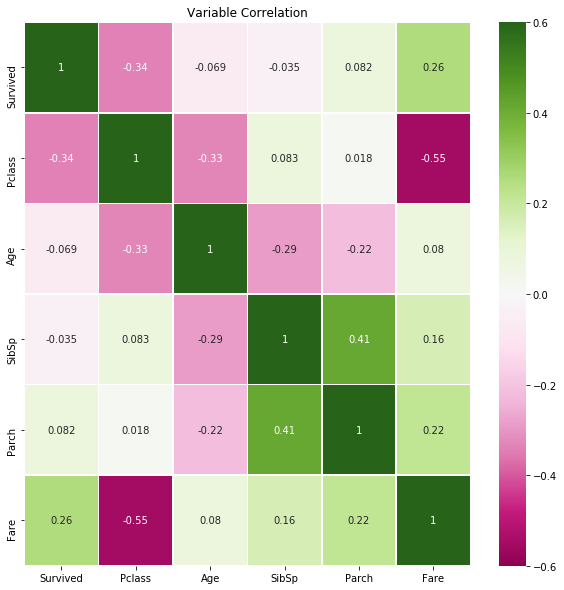

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
corr = train_1.corr()
corr_heatmap = sns.heatmap(corr, linewidths = .5, annot = True, vmin = -0.6, vmax = 0.6, cmap="PiYG")
corr_heatmap.set_title('Variable Correlation')
plt.show()

While there are some moderate correlations between variables, they are not significant enough to remove from the model.

### Getting Dummies ###
Transforming object variables to a type that can be handled with the logistic regression model.

In [14]:
all_data = all_data.astype(dtype = {'Pclass': object})
all_data_1 = pd.get_dummies(all_data)

## Modeling ##

In [15]:
train_2 = all_data_1[0:train_1.shape[0]]
train_features = train_2.drop(columns = 'Survived')

X_train, X_val, y_train, y_val = train_test_split(train_features, train_2[['Survived']], test_size = 0.5, random_state = 1)

In [16]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

score = lr.score(X_val, y_val)
print(score)

0.7825112107623319


C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Phoenix\Anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression produces around 78% accuracy.

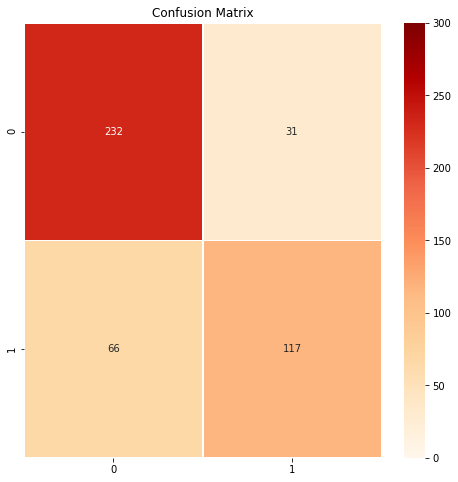

In [17]:
predictions = lr.predict(X_val)
cm = metrics.confusion_matrix(y_val, predictions)

fig, ax = plt.subplots(figsize=(8,8))
cm_heatmap = sns.heatmap(cm, annot = True, linewidths = .5, vmin = 0, vmax = 300, cmap="OrRd", fmt = "g")
cm_heatmap.set_title('Confusion Matrix')
plt.show()

According to the confusion matrix above, 12% of passengers that died were predicted as having lived, and 36% of passengers that lived were predicted as having died.

## Submission to Kaggle Competition ##
Prior to submitting my predictions into the Kaggle competition, I want to learn and explore other logistic regression algorithms. From there, I can compare the results of different algorithms and submit the one I feel will perform best.